In [1]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import keras
import tensorflow as tf

from helper import *
from connection import *

# build training data

In [2]:
# import data
df = pd.read_csv("data/raw_percentile_time5.csv")
df

,id,patient_id,task_type_id,task_level,completed_task_count,accuracy,condition_since,birth_year,start_time,start_time_min,end_time_min,deficit_id,disorder_id,domain_id,progression_order,percentile
0,24003939,15796,20,5,5,0.850,5y,1950,2020-04-17,2020-04-17 16:16:37,2020-04-17 16:22:28,"{1, 2, 3, 4, 8}","{2, 3}",1,4,0.402837
1,17594498,27987,20,5,5,0.875,5y,1953,2019-05-11,2019-05-11 14:15:24,NaN,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.402837
2,18379970,27987,20,5,1,1.000,5y,1953,2019-06-21,2019-06-21 13:46:17,NaN,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.402837
3,20401349,27987,20,5,5,0.862,5y,1953,2019-10-09,2019-10-09 18:18:17,2019-10-09 18:44:53,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.402837
4,20456915,27987,20,5,5,0.888,5y,1953,2019-10-12,2019-10-12 17:59:21,2019-10-12 18:03:47,"{1, 2, 3, 4, 5, 6, 7, 8}",{3},1,4,0.402837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405030,23397692,73017,56,6,13,0.695,6m,1959,2020-03-16,2020-03-16 14:45:08,2020-03-16 14:59:40,"{2, 4, 5, 6, 7, 8}",{2},12,26,0.911901
405031,5325432,79263,56,3,4,0.950,6m,1939,2017-01-28,2017-01-28 20:01:36,NaN,"{8, 5, 6, 7}",{2},12,10,0.405029
405032,5802448,94930,71,2,8,1.000,6m,1959,2017-01-23,2017-01-23 15:19:57,NaN,"{1, 6}",{2},10,24,1.000000
405033,14021229,177029,88,5,2,0.000,2y,1955,2018-11-04,2018-11-04 14:09:48,NaN,"{1, 4, 5, 6, 7}",{1},13,30,0.976744


In [3]:
df.nunique()

id                      405035
patient_id                3833
task_type_id                73
task_level                  12
completed_task_count        37
accuracy                  1019
condition_since              9
birth_year                  92
start_time                 733
start_time_min          396835
end_time_min            384662
deficit_id                 590
disorder_id                149
domain_id                   13
progression_order           33
percentile                 220
dtype: int64

In [4]:
# make column name array
def column_name_f(n):
    output = ["info"]
    for i in range(1, n+1):
        output.append("domain %d true" %(i))
        output.append("domain %d comp" %(i))
    return output

In [5]:
# given a patient's data, create a dataframe of scores, patient id
def create_training_data(data):
    data = data.sort_values(by="start_time_min").reset_index() # sort data
    n_sessions = data.shape[0]
    n_domains = 14
    output_array = np.zeros((n_domains * 2, n_sessions))
    i = 0

    for idx, row in data.iterrows():
        d = row["domain_id"]
        p = row["percentile"]

        # update output array
        if i != 0: output_array[:, i] = output_array[:, i-1]
        output_array[d*2-2, i] = p # score
        output_array[d*2-1, i] = 1-p # 1-score

        i += 1
    return output_array

In [6]:
# takes about ~2 min to run
train_X = np.array([])
df_groups = df.groupby("patient_id")
df_groups.groups
keys = df_groups.groups.keys()
for key in keys:
    data = df_groups.get_group(key)
    temp = create_training_data(data)
    if train_X.size == 0:
        train_X = temp
    else:
        train_X = np.hstack((train_X, temp)) 
train_X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
temp_df = pd.DataFrame(train_X)
temp_df.to_csv("data/autoencoder_train_1.csv", index=False)

# Simple Autoencoder

In [8]:
## build autoencoder
from keras import layers

n_domain = 14 # number of domains

encoding_dim = 3
## input n_domain * 2 to represent missing values
input_layer = keras.Input(shape=(n_domain * 2,))
encode_layer = layers.Dense(encoding_dim, activation="relu")(input_layer)
decode_layer = layers.Dense(n_domain, activation="sigmoid")(encode_layer)

autoencoder = keras.Model(input_layer, decode_layer)

In [9]:
# build encoder and decoder model
encoder = keras.Model(input_layer, encode_layer)
encoded_input = keras.Input(shape=(encoding_dim,))
decode_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decode_layer(encoded_input))

In [10]:
# compile with optimizer and loss function
autoencoder.compile(optimizer="adam", loss="mae")

### Training

In [11]:
train = train_X.copy()
train = np.transpose(train)
train.shape

(405035, 28)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test = train_test_split(train, test_size=0.20, random_state=42)
x_train, x_val = train_test_split(x_train, test_size=0.25, random_state=42)

In [13]:
tf.config.run_functions_eagerly(True)

In [14]:
output = autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/25
 42/950 [>.............................] - ETA: 2s - loss: 0.3949

/Users/964505/CT/ct_research/ct/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


950/950 [==============================] - 3s 3ms/step - loss: 0.2244 - val_loss: 0.1683
Epoch 2/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1556 - val_loss: 0.1481
Epoch 3/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1449 - val_loss: 0.1427
Epoch 4/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1409 - val_loss: 0.1394
Epoch 5/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1376 - val_loss: 0.1361
Epoch 6/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1346 - val_loss: 0.1337
Epoch 7/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1326 - val_loss: 0.1320
Epoch 8/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1311 - val_loss: 0.1306
Epoch 9/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1299 - val_loss: 0.1296
Epoch 10/25
950/950 [==============================] - 3s 3ms/step - loss: 0.1290 - val_loss: 0.1287
Epoch 11/2

### Evaluation

In [15]:
x_test_encoded = encoder.predict(x_test, batch_size=256)

317/317 [==============================] - 0s 326us/step


In [16]:
x_decoded = decoder.predict(x_test_encoded)

2532/2532 [==============================] - 1s 323us/step


In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [18]:
mean_absolute_error(x_test, x_decoded, multioutput="raw_values")

array([2.11214295e-01, 1.96084634e-01, 2.22515260e-01, 2.00794394e-01,
       1.44641357e-01, 1.99969598e-01, 6.10574222e-02, 1.98993004e-01,
       1.12826089e-01, 1.43250712e-01, 1.85650588e-01, 1.95033199e-01,
       6.25694378e-03, 4.21210423e-03, 9.47113717e-02, 8.24837967e-02,
       1.14486049e-01, 1.10584387e-01, 2.76173644e-01, 1.96415942e-01,
       4.83320266e-07, 5.22392474e-07, 1.77524692e-01, 2.33708007e-01,
       1.60220943e-03, 2.13909301e-03, 4.75281215e-02, 6.54504476e-02])

In [19]:
mean_absolute_error(x_test, x_decoded)

0.12447529889388301

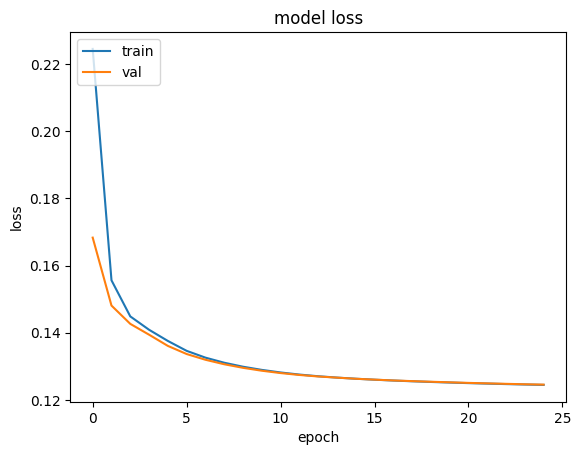

In [20]:
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
## all zero test case, expecting it to return averages

all_zeros = np.zeros((1, 28))
all_zeros_encoded = encoder.predict(all_zeros, batch_size=256)
all_zeros_decoded = decoder.predict(all_zeros_encoded)

1/1 [==============================] - 0s 8ms/step


/Users/964505/CT/ct_research/ct/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [22]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
all_zeros_decoded

array([[0.000000, 0.000000, 0.063890, 0.006645, 0.000000, 0.065478,
        0.000046, 0.089785, 0.059816, 0.009286, 0.000000, 0.000000,
        0.000000, 0.000000, 0.000000, 0.000000, 0.003316, 0.001644,
        0.000000, 0.000000, 0.000000, 0.000000, 0.253019, 0.329752,
        0.000000, 0.000000, 0.000000, 0.000000]], dtype=float32)

# Variational Autoencoder

In [23]:
original_dim = n_domain * 2
intermediate_dim = n_domain
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [24]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [25]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [26]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [29]:
output = vae.fit(x_train, x_train,
        epochs=15,
        batch_size=32,
        validation_data=(x_val, x_val))

Epoch 1/15
  16/7595 [..............................] - ETA: 51s - loss: 9.3814

/Users/964505/CT/ct_research/ct/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


7595/7595 [==============================] - 53s 7ms/step - loss: 9.3906 - val_loss: 9.4194
Epoch 2/15
7595/7595 [==============================] - 53s 7ms/step - loss: 9.3886 - val_loss: 9.4086
Epoch 3/15
7595/7595 [==============================] - 54s 7ms/step - loss: 9.3883 - val_loss: 9.4112
Epoch 4/15
7595/7595 [==============================] - 54s 7ms/step - loss: 9.3881 - val_loss: 9.4047
Epoch 5/15
7595/7595 [==============================] - 54s 7ms/step - loss: 9.3884 - val_loss: 9.4006
Epoch 6/15
7595/7595 [==============================] - 54s 7ms/step - loss: 9.3884 - val_loss: 9.3970
Epoch 7/15
7595/7595 [==============================] - 53s 7ms/step - loss: 9.3868 - val_loss: 9.3954
Epoch 8/15
7595/7595 [==============================] - 53s 7ms/step - loss: 9.3849 - val_loss: 9.4091
Epoch 9/15
7595/7595 [==============================] - 53s 7ms/step - loss: 9.3837 - val_loss: 9.4011
Epoch 10/15
7595/7595 [==============================] - 54s 7ms/step - loss: 9.3841

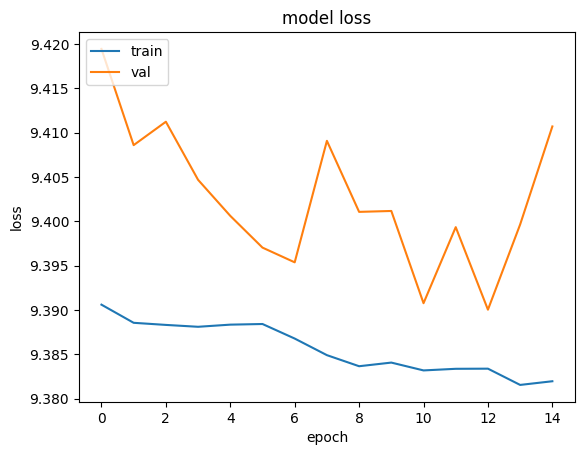

Bad pipe message: %s [b'A\xb3\x9e@}\x93#j\xcf`l\xfe\xe6\xb6\x98*u\x94\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00']
Bad pipe message: %s [b'\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x00']
Bad pipe message: %s [b"'\x1a0\xf6\xedd\x04\xdb\xe5]\x80+1}\x7f:\xc1T\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n"]
Bad pipe message: %s [b'K\x87\xe7\xc6.\xf4)|E\x83\x92\ty\x91p\xa0\x1cN\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x

In [30]:
plt.plot(output.history['loss'])
plt.plot(output.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# not sure what to name this yet

In [ ]:
def custom_mse(y_true, y_pred):
    n_domain = len(y_true) // 2
    for i in range(n_domain):
        # if missing, then modify target
        if y_true[i*2] == 0 and y_true[i*2+1] == 0:
            y_true[i*2] = y_pred[i*2]
            y_true[i*2+1] = y_pred[i*2+1]

    # calculate mse as 
    mse = tf.keras.losses.MeanSquaredError()
    return mse(y_true, y_pred).numpy()

In [ ]:
def custom_mae(y_true, y_pred):
    n_domain = len(y_true) // 2
    for i in range(n_domain):
        # if missing, then modify target
        if y_true[i*2] == 0 and y_true[i*2+1] == 0:
            y_true[i*2] = y_pred[i*2]
            y_true[i*2+1] = y_pred[i*2+1]

    # calculate mse as 
    mse = tf.keras.losses.MeanAbsoluteError()
    return mse(y_true, y_pred).numpy()